Installs 

In [39]:
pip install streamlit pandas numpy plotly yfinance -q

In [40]:
import csv
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from base64 import encode
import requests,string,time
from statistics import mean
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle

class ML_Core:
  def run_ML(self, input_wallet):
    df = pd.read_csv('./transaction_dataset.csv', index_col=0)
    # Ommit first two columns (Index, Adress)
    df = df.iloc[:,2:]
    # Turn object variables into 'category' dtype for more computation efficiency
    categories = df.select_dtypes('O').columns.astype('category')


    # Inspect target distribution
    print(df['FLAG'].value_counts())
    pie, ax = plt.subplots(figsize=[15,10])
    labels = ['Non-fraud', 'Fraud']
    colors = ['#f9ae35', '#f64e38']
    plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
    plt.title('Target distribution')
    plt.show()


    # Correlation matrix
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)]=True
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(18,10))
        sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)


    # Visualize missings pattern of the dataframe
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()


    # Drop the two categorical features
    df.drop(df[categories], axis=1, inplace=True)
    # Replace missings of numerical variables with median
    df.fillna(df.median(), inplace=True)
    # Visualize missings pattern of the dataframe
    print(df.shape)
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()


    # Filtering the features with 0 variance
    no_var = df.var() == 0
    print(df.var()[no_var])
    print('\n')

    # Drop features with 0 variance --- these features will not help in the performance of the model
    df.drop(df.var()[no_var].index, axis = 1, inplace = True)
    print(df.var())
    print(df.shape)

    # Recheck the Correlation matrix
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)]=True
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(18,10))
        sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

    drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
            ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
            ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
            'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
    df.drop(drop, axis=1, inplace=True)

    # Recheck the Correlation matrix
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)]=True
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(18,10))
        sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

    columns = df.columns
    columns
    # Some features present a small distribution
    for i in df.columns[1:]:
        if len(df[i].value_counts()) < 10:
            print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
            print('======================================')
    drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
    df.drop(drops, axis=1, inplace=True)


    y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    # Split into training (80%) and testing set (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
    df_orig = pd.read_csv('./transaction_dataset.csv', index_col=0)
    df_input = df_orig[df_orig['Address'] == input_wallet.lower()]
    df_input = df_input[['Avg min between sent tnx', 'Avg min between received tnx',
          'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
          'Number of Created Contracts', 'max value received ',
          'avg val received', 'avg val sent',
          'total Ether sent', 'total ether balance',
          ' ERC20 total Ether received', ' ERC20 total ether sent',
          ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
          ' ERC20 uniq rec token name']]
    norm = PowerTransformer()
    norm_train_f = norm.fit_transform(X_train)
    norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
    oversample = SMOTE()

    x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
    # Target distribution before SMOTE
    non_fraud = 0
    fraud = 0

    for i in y_train:
        if i == 0:
            non_fraud +=1
        else:
            fraud +=1

    # Target distribution after SMOTE
    no = 0
    yes = 1

    for j in y_tr_resample:
        if j == 0:
            no +=1
        else:
            yes +=1

    RF = RandomForestClassifier(random_state=42)
    RF.fit(x_tr_resample, y_tr_resample)
    preds = 0.0 #RF.predict(df_input)
    pred_prob = [[0.0, 0.0]] #RF.predict_proba(df_input)
    inval = 100
    if(df_input.empty):
      return -1 , -1
    for val in range(inval):
      if(df_input.isnull().values.any()):
        return -1 , -1
      preds += RF.predict(df_input)
      pred_prob[0][0] += RF.predict_proba(df_input)[0][0]
      pred_prob[0][1] += RF.predict_proba(df_input)[0][1]
    print(preds)
    print(pred_prob)
    return round(preds[0]/inval), [[pred_prob[0][0]/inval,pred_prob[0][1]/inval]]
class DataTool:
    def __init__(self,direct=False):
        self.direct = direct
        self.key = ""

    def main_nw(self,clean_addresses=True,name='clean_addresses',direct_addresses=[],idx=1, mode=0):
        addresses = []
        name = name
        flag = 0 if clean_addresses else 1
        if self.direct == False:
            if clean_addresses == True:
                addresses = np.array(pd.read_csv('clean_adresses.csv')['Address'])
                flag = 0
            else:
                addresses = self.get_scam_addresses()
                flag = 1
        else:
            name = 'transaction_dataset'
            addresses = direct_addresses
        index = idx
        #for address in addresses:
        #    normal_tnxs, WoIT_N, kyc_N = self.normal_transactions(index, address, flag=flag)
        #    token_transfer_tnxs, WoIT_T, kyc_T = self.token_transfer_transactions(address)
        address = addresses[0]
        if mode == 0:
          return self.normal_transactions(index, address, flag=flag)
        elif mode == 1:
          return self.token_transfer_transactions(address)
        else:
          return self.NFT_transfer_transactions(address)

    def main(self,clean_addresses=True,name='clean_addresses',direct_addresses=[],idx=1):
        addresses = []
        name = name
        flag = 0 if clean_addresses else 1
        if self.direct == False:
            if clean_addresses == True:
                addresses = np.array(pd.read_csv('clean_adresses.csv')['Address'])
                flag = 0
            else:
                addresses = self.get_scam_addresses()
                flag = 1
        else:
            name = 'transaction_dataset'
            addresses = direct_addresses
        index = idx
        pbar = tqdm(total=len(addresses))
        for address in addresses:
            normal_tnxs, WoIT_N, kyc_N = self.normal_transactions(index, address, flag=flag)
            token_transfer_tnxs, WoIT_T, kyc_T = self.token_transfer_transactions(address)
            if(normal_tnxs[2] != 0 and len(normal_tnxs[2].lower()) == 42 and normal_tnxs[2].lower() != '0x0000000000000000000000000000000000000000' and normal_tnxs[2].lower()[:2] == '0x'):
              try:
                  all_tnxs = np.concatenate((normal_tnxs, token_transfer_tnxs), axis=None)
                  with open(r'./{}.csv'.format(name), 'a', newline="") as f:
                      writer = csv.writer(f, delimiter=',')
                      writer.writerow(all_tnxs)
                  index += 1
                  pbar.update(1)
                  #all_tnxs = np.concatenate((list(WoIT_T.items()),[kyc_T],list(WoIT_T.items()),[kyc_N]), axis=None)
                  #with open(r'./{}.csv'.format('direct'), 'a', newline="") as f:
                  #    writer = csv.writer(f, delimiter='|')
                  #    writer.writerow(all_tnxs)
              except:
                  continue
            else:
              print(normal_tnxs)
        pbar.close()

        if name == 'direct':
            df = pd.read_csv('transaction_dataset.csv',header=None)
            return df

    def token_transfer_transactions(self,address):
        URL = ("http://api.etherscan.io/api?module=account&action=tokentx&address={address}&startblock=0&endblock=999999999&sort=asc&apikey="+self.key).format(address=address)

        r = requests.get(url=URL)
        data = r.json()
        timestamp, recipients, timeDiffSent, timeDiffReceive, timeDiffContractTnx, receivedFromAddresses, receivedFromContractAddress, \
        sentToAddresses, sentToContractAddresses, sentToContracts, valueSent, valueReceived, valueSentContracts, \
        tokenReceivedName, tokenReceivedSymbol, tokenSentName, tokenSentSymbol, valueReceivedContract, sentToAddressesContract,\
        receivedFromAddressesContract, tokenSentNameContract, tokenSentSymbolContract = ([] for i in range(22))

        receivedTransactions, sentTransactions, minValReceived, tokenContractTnx, \
        maxValReceived, avgValReceived, minValSent, maxValSent, avgValSent, minValSentContract, \
        maxValSentContract, avgValSentContract = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        ERC20_contract_tnx_fields = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        WoIT = {}
        kyc = "None"
        if data['status'] != '0':
            for tokenTnx in range(len(data['result'])):
                timestamp.append(data['result'][tokenTnx]['timeStamp'][0])

                # if receiving
                if data['result'][tokenTnx]['to'] == address:
                    receivedTransactions = receivedTransactions + 1
                    receivedFromAddresses.append(data['result'][tokenTnx]['from'])
                    receivedFromContractAddress.append(data['result'][tokenTnx]['contractAddress'])
                    valueReceived.append(int(data['result'][tokenTnx]['value']) / 1000000000000000000)

                    if data['result'][tokenTnx]['tokenName'] is not None:
                        tName = data['result'][tokenTnx]['tokenName']
                        tName.translate(str.maketrans('', '', string.punctuation))
                        tokenReceivedName.append(tName.encode("utf-8"))
                    tokenReceivedSymbol.append(data['result'][tokenTnx]['tokenSymbol'])
                    if receivedTransactions > 0:
                        timeDiffReceive.append((datetime.utcfromtimestamp(int(timestamp[tokenTnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tokenTnx - 1]))).total_seconds() / 60)

                # if sending
                if data['result'][tokenTnx]['from'] == address:
                    sentTransactions = sentTransactions + 1
                    sentToAddresses.append(data['result'][tokenTnx]['to'])
                    sentToContractAddresses.append(data['result'][tokenTnx]['contractAddress'])
                    valueSent.append(int(data['result'][tokenTnx]['value']) / 1000000000000000000)
                    if data['result'][tokenTnx]['tokenName'] is not None:
                        tName = data['result'][tokenTnx]['tokenName']
                        tName.translate(str.maketrans('', '', string.punctuation))
                        tokenSentName.append(tName.encode("utf-8"))

                    tokenSentSymbol.append(data['result'][tokenTnx]['tokenSymbol'])
                    if sentTransactions > 0:
                        timeDiffSent.append((datetime.utcfromtimestamp(int(timestamp[tokenTnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tokenTnx - 1]))).total_seconds() / 60)

                # if a contract
                if data['result'][tokenTnx]['contractAddress'] == address:
                    tokenContractTnx = tokenContractTnx + 1
                    valueReceivedContract.append(int(data['result'][tokenTnx]['value']) / 1000000000000000000)
                    sentToAddressesContract.append(data['result'][tokenTnx]['to'])
                    receivedFromAddressesContract.append(data['result'][tokenTnx]['from'])
                    if data['result'][tokenTnx]['tokenName'] is not None:
                        tokenSentNameContract.append((data['result'][tokenTnx]['tokenName']).encode("utf-8"))
                    tokenSentSymbolContract.append(data['result'][tokenTnx]['tokenSymbol'])
                    if tokenContractTnx > 0:
                        timeDiffContractTnx.append((datetime.utcfromtimestamp(int(timestamp[tokenTnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tokenTnx - 1]))).total_seconds() / 60)
            
            
            for i in range(len(sentToAddresses)):
                WoIT[sentToAddresses[i]] = (WoIT[sentToAddresses[i]][0] + valueSent[i], WoIT[sentToAddresses[i]][1], WoIT[sentToAddresses[i]][2] + 1.0) if sentToAddresses[i] in WoIT else (valueSent[i], 0.0, 1.0)
            for i in range(len(receivedFromAddresses)):
                WoIT[receivedFromAddresses[i]] = (WoIT[receivedFromAddresses[i]][0], WoIT[receivedFromAddresses[i]][1] + valueReceived[i], WoIT[receivedFromAddresses[i]][2] + 1.0) if receivedFromAddresses[i] in WoIT else (0.0, valueReceived[i], 1.0)

            kycdf = pd.read_csv('./kyc.csv', index_col=0)
            
            for idx, row in kycdf.iterrows():
              if (row['wallet'].lower() in WoIT):
                kyc = row['exchange']

            #print(WoIT, "\n\n\n", kyc)
            totalTnx = receivedTransactions + sentTransactions + tokenContractTnx
            totalEtherRec = np.sum(valueReceived)
            totalEtherSent = np.sum(valueSent)
            totalEtherContract = np.sum(valueReceivedContract)
            uniqSentAddr, uniqRecAddr = len(np.unique(sentToAddresses)) if sentToAddresses else 0, len(np.unique(receivedFromAddresses)) if receivedFromAddresses else 0
            uniqSentContAddr, uniqRecContAddr = len(np.unique(sentToAddressesContract)) if sentToAddressesContract else 0, len(np.unique(receivedFromContractAddress)) if receivedFromContractAddress else 0
            avgTimeBetweenSentTnx =  "{0:.2f}".format(mean(timeDiffSent)) if len(timeDiffSent) > 1 else 0
            avgTimeBetweenRecTnx =  "{0:.2f}".format(mean(timeDiffReceive)) if len(timeDiffReceive) > 1 else 0
            avgTimeBetweenContractTnx =  "{0:.2f}".format(mean(timeDiffContractTnx)) if len(timeDiffContractTnx) > 1 else 0
            (minValReceived, maxValReceived, avgValReceived) = ("{0:.6f}".format(min(valueReceived)), "{0:.6f}".format(max(valueReceived)), "{0:.6f}".format(mean(valueReceived))) if valueReceived else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            (minValSent, maxValSent, avgValSent) = ("{0:.6f}".format(min(valueSent)), "{0:.6f}".format(max(valueSent)), "{0:.6f}".format(mean(valueSent))) if valueSent else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            (minValSentContract, maxValSentContract, avgValSentContract) = ("{0:.6f}".format(min(valueSentContracts)), "{0:.6f}".format(max(valueSentContracts)), "{0:.6f}".format(mean(valueSentContracts))) if valueSentContracts else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            uniqSentTokenName = len(np.unique(tokenSentName))
            uniqRecTokenName = len(np.unique(tokenReceivedName))
            if len(tokenSentName) > 0:
                mostSentTokenType = max(set(tokenSentName), key = tokenSentName.count)
            else:
                mostSentTokenType = "None"

            if len(tokenReceivedName) > 0:
                mostRecTokenType = max(set(tokenReceivedName), key = tokenReceivedName.count)
            else:
                mostRecTokenType = "None"

            ERC20_contract_tnx_fields = [totalTnx, totalEtherRec, totalEtherSent, totalEtherContract, uniqSentAddr, uniqRecAddr,
                                         uniqSentContAddr, uniqRecContAddr, avgTimeBetweenSentTnx, avgTimeBetweenRecTnx, avgTimeBetweenRecTnx, avgTimeBetweenContractTnx,
                                         minValReceived, maxValReceived, avgValReceived, minValSent, maxValSent, avgValSent, minValSentContract, maxValSentContract, avgValSentContract,
                                         uniqSentTokenName, uniqRecTokenName, mostSentTokenType, mostRecTokenType]
        return ERC20_contract_tnx_fields, WoIT,kyc

    def NFT_transfer_transactions(self,address):
        URL = ("http://api.etherscan.io/api?module=account&action=tokennfttx&address={address}&startblock=0&endblock=999999999&sort=asc&apikey="+self.key).format(address=address)

        r = requests.get(url=URL)
        data = r.json()
        timestamp, recipients, timeDiffSent, timeDiffReceive, timeDiffContractTnx, receivedFromAddresses, receivedFromContractAddress, \
        sentToAddresses, sentToContractAddresses, sentToContracts, valueSent, valueReceived, valueSentContracts, \
        tokenReceivedName, tokenReceivedSymbol, tokenSentName, tokenSentSymbol, valueReceivedContract, sentToAddressesContract,\
        receivedFromAddressesContract, tokenSentNameContract, tokenSentSymbolContract = ([] for i in range(22))

        receivedTransactions, sentTransactions, minValReceived, tokenContractTnx, \
        maxValReceived, avgValReceived, minValSent, maxValSent, avgValSent, minValSentContract, \
        maxValSentContract, avgValSentContract = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        ERC20_contract_tnx_fields = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        WoIT = {}
        kyc = "None"
        if data['status'] != '0':
            for tokenTnx in range(len(data['result'])):
                timestamp.append(data['result'][tokenTnx]['timeStamp'][0])

                # if receiving
                if data['result'][tokenTnx]['to'] == address:
                    receivedTransactions = receivedTransactions + 1
                    receivedFromAddresses.append(data['result'][tokenTnx]['from'])
                    receivedFromContractAddress.append(data['result'][tokenTnx]['contractAddress'])
                    valueReceived.append(int(data['result'][tokenTnx]['cumulativeGasUsed']) / 1000000000000000000)

                    if data['result'][tokenTnx]['tokenName'] is not None:
                        tName = data['result'][tokenTnx]['tokenName']
                        tName.translate(str.maketrans('', '', string.punctuation))
                        tokenReceivedName.append(tName.encode("utf-8"))
                    tokenReceivedSymbol.append(data['result'][tokenTnx]['tokenSymbol'])
                    if receivedTransactions > 0:
                        timeDiffReceive.append((datetime.utcfromtimestamp(int(timestamp[tokenTnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tokenTnx - 1]))).total_seconds() / 60)

                # if sending
                if data['result'][tokenTnx]['from'] == address:
                    sentTransactions = sentTransactions + 1
                    sentToAddresses.append(data['result'][tokenTnx]['to'])
                    sentToContractAddresses.append(data['result'][tokenTnx]['contractAddress'])
                    valueSent.append(int(data['result'][tokenTnx]['cumulativeGasUsed']) / 1000000000000000000)
                    if data['result'][tokenTnx]['tokenName'] is not None:
                        tName = data['result'][tokenTnx]['tokenName']
                        tName.translate(str.maketrans('', '', string.punctuation))
                        tokenSentName.append(tName.encode("utf-8"))

                    tokenSentSymbol.append(data['result'][tokenTnx]['tokenSymbol'])
                    if sentTransactions > 0:
                        timeDiffSent.append((datetime.utcfromtimestamp(int(timestamp[tokenTnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tokenTnx - 1]))).total_seconds() / 60)

                # if a contract
                if data['result'][tokenTnx]['contractAddress'] == address:
                    tokenContractTnx = tokenContractTnx + 1
                    valueReceivedContract.append(int(data['result'][tokenTnx]['cumulativeGasUsed']) / 1000000000000000000)
                    sentToAddressesContract.append(data['result'][tokenTnx]['to'])
                    receivedFromAddressesContract.append(data['result'][tokenTnx]['from'])
                    if data['result'][tokenTnx]['tokenName'] is not None:
                        tokenSentNameContract.append((data['result'][tokenTnx]['tokenName']).encode("utf-8"))
                    tokenSentSymbolContract.append(data['result'][tokenTnx]['tokenSymbol'])
                    if tokenContractTnx > 0:
                        timeDiffContractTnx.append((datetime.utcfromtimestamp(int(timestamp[tokenTnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tokenTnx - 1]))).total_seconds() / 60)
            

            for i in range(len(sentToAddresses)):
                WoIT[sentToAddresses[i]] = (WoIT[sentToAddresses[i]][0] + valueSent[i], WoIT[sentToAddresses[i]][1], WoIT[sentToAddresses[i]][2] + 1.0) if sentToAddresses[i] in WoIT else (valueSent[i], 0.0, 1.0)
            for i in range(len(receivedFromAddresses)):
                WoIT[receivedFromAddresses[i]] = (WoIT[receivedFromAddresses[i]][0], WoIT[receivedFromAddresses[i]][1] + valueReceived[i], WoIT[receivedFromAddresses[i]][2] + 1.0) if receivedFromAddresses[i] in WoIT else (0.0, valueReceived[i], 1.0)

            kycdf = pd.read_csv('./kyc.csv', index_col=0)
            
            for idx, row in kycdf.iterrows():
              if (row['wallet'].lower() in WoIT):
                kyc = row['exchange']

            #print(WoIT, "\n\n\n", kyc)
            totalTnx = receivedTransactions + sentTransactions + tokenContractTnx
            totalEtherRec = np.sum(valueReceived)
            totalEtherSent = np.sum(valueSent)
            totalEtherContract = np.sum(valueReceivedContract)
            uniqSentAddr, uniqRecAddr = len(np.unique(sentToAddresses)) if sentToAddresses else 0, len(np.unique(receivedFromAddresses)) if receivedFromAddresses else 0
            uniqSentContAddr, uniqRecContAddr = len(np.unique(sentToAddressesContract)) if sentToAddressesContract else 0, len(np.unique(receivedFromContractAddress)) if receivedFromContractAddress else 0
            avgTimeBetweenSentTnx =  "{0:.2f}".format(mean(timeDiffSent)) if len(timeDiffSent) > 1 else 0
            avgTimeBetweenRecTnx =  "{0:.2f}".format(mean(timeDiffReceive)) if len(timeDiffReceive) > 1 else 0
            avgTimeBetweenContractTnx =  "{0:.2f}".format(mean(timeDiffContractTnx)) if len(timeDiffContractTnx) > 1 else 0
            (minValReceived, maxValReceived, avgValReceived) = ("{0:.6f}".format(min(valueReceived)), "{0:.6f}".format(max(valueReceived)), "{0:.6f}".format(mean(valueReceived))) if valueReceived else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            (minValSent, maxValSent, avgValSent) = ("{0:.6f}".format(min(valueSent)), "{0:.6f}".format(max(valueSent)), "{0:.6f}".format(mean(valueSent))) if valueSent else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            (minValSentContract, maxValSentContract, avgValSentContract) = ("{0:.6f}".format(min(valueSentContracts)), "{0:.6f}".format(max(valueSentContracts)), "{0:.6f}".format(mean(valueSentContracts))) if valueSentContracts else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            uniqSentTokenName = len(np.unique(tokenSentName))
            uniqRecTokenName = len(np.unique(tokenReceivedName))
            if len(tokenSentName) > 0:
                mostSentTokenType = max(set(tokenSentName), key = tokenSentName.count)
            else:
                mostSentTokenType = "None"

            if len(tokenReceivedName) > 0:
                mostRecTokenType = max(set(tokenReceivedName), key = tokenReceivedName.count)
            else:
                mostRecTokenType = "None"

            ERC20_contract_tnx_fields = [totalTnx, totalEtherRec, totalEtherSent, totalEtherContract, uniqSentAddr, uniqRecAddr,
                                         uniqSentContAddr, uniqRecContAddr, avgTimeBetweenSentTnx, avgTimeBetweenRecTnx, avgTimeBetweenRecTnx, avgTimeBetweenContractTnx,
                                         minValReceived, maxValReceived, avgValReceived, minValSent, maxValSent, avgValSent, minValSentContract, maxValSentContract, avgValSentContract,
                                         uniqSentTokenName, uniqRecTokenName, mostSentTokenType, mostRecTokenType]
        return ERC20_contract_tnx_fields, WoIT, kyc

    def normal_transactions(self,index, address, flag):
        URL = ("https://api.etherscan.io/api?module=account&action=txlist&address={address}&startblock=0&endblock=99999999&page=1&offset=10000&sort=asc&apikey="+self.key).format(address=address)

        r = requests.get(url=URL)
        data = r.json()

        timestamp, recipients, timeDiffSent, timeDiffReceive, receivedFromAddresses, \
        sentToAddresses, sentToContracts, valueSent, valueReceived, valueSentContracts = ([] for i in range(10))
        receivedTransactions, sentTransactions, createdContracts, minValReceived, \
        maxValReceived, avgValReceived, minValSent, maxValSent, avgValSent, minValSentContract, \
        maxValSentContract, avgValSentContract = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        transaction_fields = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        WoIT = {}
        kyc = "None"

        if data['status'] != '0':
            for tnx in range(len(data['result'])):
                if data['result'][tnx]['isError'] == 1:
                    pass
                timestamp.append(data['result'][tnx]['timeStamp'])
                if data['result'][tnx]['to'] == address:
                    receivedTransactions = receivedTransactions + 1
                    receivedFromAddresses.append(data['result'][tnx]['from'])
                    valueReceived.append(int(data['result'][tnx]['value']) / 1000000000000000000)
                    if receivedTransactions > 0:
                        timeDiffReceive.append((datetime.utcfromtimestamp(int(timestamp[tnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tnx - 1]))).total_seconds() / 60)
                if data['result'][tnx]['from'] == address:
                    sentTransactions = sentTransactions + 1
                    sentToAddresses.append(data['result'][tnx]['to'])
                    valueSent.append(int(data['result'][tnx]['value']) / 1000000000000000000)
                    if sentTransactions > 0:
                        timeDiffSent.append((datetime.utcfromtimestamp(int(timestamp[tnx])) - datetime.utcfromtimestamp(
                            int(timestamp[tnx - 1]))).total_seconds() / 60)

                if data['result'][tnx]['contractAddress'] != '':
                    createdContracts = createdContracts + 1
                    sentToContracts.append(data['result'][tnx]['contractAddress'])
                    valueSentContracts.append(int(data['result'][tnx]['value']) / 1000000000000000000)

            
            for i in range(len(sentToAddresses)):
                WoIT[sentToAddresses[i]] = (WoIT[sentToAddresses[i]][0] + valueSent[i], WoIT[sentToAddresses[i]][1], WoIT[sentToAddresses[i]][2] + 1.0) if sentToAddresses[i] in WoIT else (valueSent[i], 0.0, 1.0)
            for i in range(len(receivedFromAddresses)):
                WoIT[receivedFromAddresses[i]] = (WoIT[receivedFromAddresses[i]][0], WoIT[receivedFromAddresses[i]][1] + valueReceived[i], WoIT[receivedFromAddresses[i]][2] + 1.0) if receivedFromAddresses[i] in WoIT else (0.0, valueReceived[i], 1.0)

            kycdf = pd.read_csv('./kyc.csv', index_col=0)
            for idx, row in kycdf.iterrows():
              if (row['wallet'].lower() in WoIT):
                kyc = row['exchange']

            #print(WoIT, "\n\n\n", kyc)
            totalTnx = sentTransactions + receivedTransactions + createdContracts
            totalEtherReceived = np.sum(valueReceived)
            totalEtherSent = np.sum(valueSent)
            totalEtherSentContracts = np.sum(valueSentContracts)
            totalEtherBalance = totalEtherReceived - totalEtherSent - totalEtherSentContracts
            avgTimeBetweenSentTnx = "{0:.2f}".format(mean(timeDiffSent)) if len(timeDiffSent) > 1 else 0
            avgTimeBetweenRecTnx = "{0:.2f}".format(mean(timeDiffReceive)) if len(timeDiffReceive) > 1 else 0
            numUniqSentAddress, numUniqRecAddress = len(np.unique(sentToAddresses)) if sentToAddresses else 0, len(np.unique(receivedFromAddresses)) if receivedFromAddresses else 0
            (minValReceived, maxValReceived, avgValReceived) = ("{0:.6f}".format(min(valueReceived)), "{0:.6f}".format(max(valueReceived)), "{0:.6f}".format(mean(valueReceived))) if valueReceived else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            (minValSent, maxValSent, avgValSent) = ("{0:.6f}".format(min(valueSent)), "{0:.6f}".format(max(valueSent)), "{0:.6f}".format(mean(valueSent))) if valueSent else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            (minValSentContract, maxValSentContract, avgValSentContract) = ("{0:.6f}".format(min(valueSentContracts)), "{0:.6f}".format(max(valueSentContracts)), "{0:.6f}".format(mean(valueSentContracts))) if valueSentContracts else ("{0:.6f}".format(0), "{0:.6f}".format(0), "{0:.6f}".format(0))
            timeDiffBetweenFirstAndLast = "{0:.2f}".format((datetime.utcfromtimestamp(int(timestamp[-1])) - datetime.utcfromtimestamp(int(timestamp[0]))).total_seconds() / 60) if len(timestamp)>0 else 0

            ILLICIT_OR_NORMAL_ACCOUNT_FLAG = flag

            transaction_fields = [index, index, address, ILLICIT_OR_NORMAL_ACCOUNT_FLAG ,avgTimeBetweenSentTnx, avgTimeBetweenRecTnx, timeDiffBetweenFirstAndLast,
                                  sentTransactions, receivedTransactions, createdContracts, numUniqRecAddress, numUniqSentAddress, minValReceived, maxValReceived, avgValReceived,
                                  minValSent, maxValSent, avgValSent, minValSentContract, maxValSentContract, avgValSentContract,
                                  totalTnx, totalEtherSent, totalEtherReceived, totalEtherSentContracts, totalEtherBalance]
        return transaction_fields, WoIT, kyc

    def account_balance(self,address):
        url = ("https://api.etherscan.io/api?module=account&action=balance&address={address}&tag=latest&apikey="+self.key).format(address=address)
        data = requests.get(url=url).json()
        return int(data['result']) / 1000000000000000000 if data['status'] != 0 else 0

    def get_scam_addresses(self):
        etherscamdb = requests.get("https://etherscamdb.info/api/scams/").json()
        mew_address_darklist = requests.get('https://raw.githubusercontent.com/MyEtherWallet/ethereum-lists/master/src/addresses/addresses-darklist.json').json()
        addresses = []
        for item in mew_address_darklist:
            addresses.append(item['address'])
        for scam in range(len(etherscamdb['result'])):
            if 'addresses' in etherscamdb['result'][scam]:
                for i in etherscamdb['result'][scam]['addresses']:
                    if i[:2] != '0x':
                        continue
                    addresses.append(i)
        return np.unique(np.char.lower(addresses))

9857
False


0it [00:00, ?it/s]

8311    1
Name: FLAG, dtype: int64
1 








AB:  0.0
7
7
['0x23554694551079e9ffc3a0d2fc6ab71b50cc677e', '0x23dc0b668d5b66ad2870370b62c84b2c2450aa08', '0xbb530108497bd5007b74443119a8de8f33cc98bf', '0x04beba5943cc844500c3115d0070428de3a44950', '0xe4b3dd9839ed1780351dc5412925cf05f07a1939', '0x564286362092d8e7936f0549571a803b203aaced', '0x4cfdcc82e4ef1d0a2719cb8cae0bf9e9db84f1c5']
[('0x4cfdcc82e4ef1d0a2719cb8cae0bf9e9db84f1c5', (1.504633636, 0.0, 1.0)), ('0x23554694551079e9ffc3a0d2fc6ab71b50cc677e', (0.0, 0.5, 1.0)), ('0x04beba5943cc844500c3115d0070428de3a44950', (0.0, 0.005998636, 1.0)), ('0xe4b3dd9839ed1780351dc5412925cf05f07a1939', (0.0, 1.0, 1.0))]
[('0x23dc0b668d5b66ad2870370b62c84b2c2450aa08', (100.0, 0.0, 1.0)), ('0xbb530108497bd5007b74443119a8de8f33cc98bf', (0.0, 99.0, 1.0)), ('0x564286362092d8e7936f0549571a803b203aaced', (0.0, 13.37, 1.0))]
[] 



========================================KYC:  Binance
None
0x4886df279cc4946941e26de30b4011a2e92d2009
0    7678
1    2179
Name: FLAG, dtype: int64


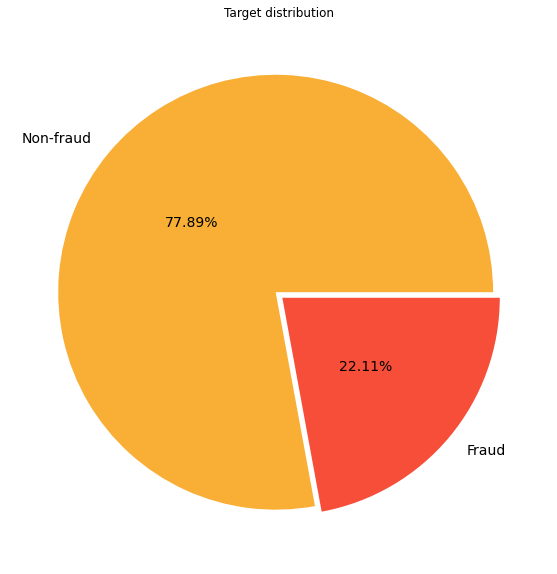

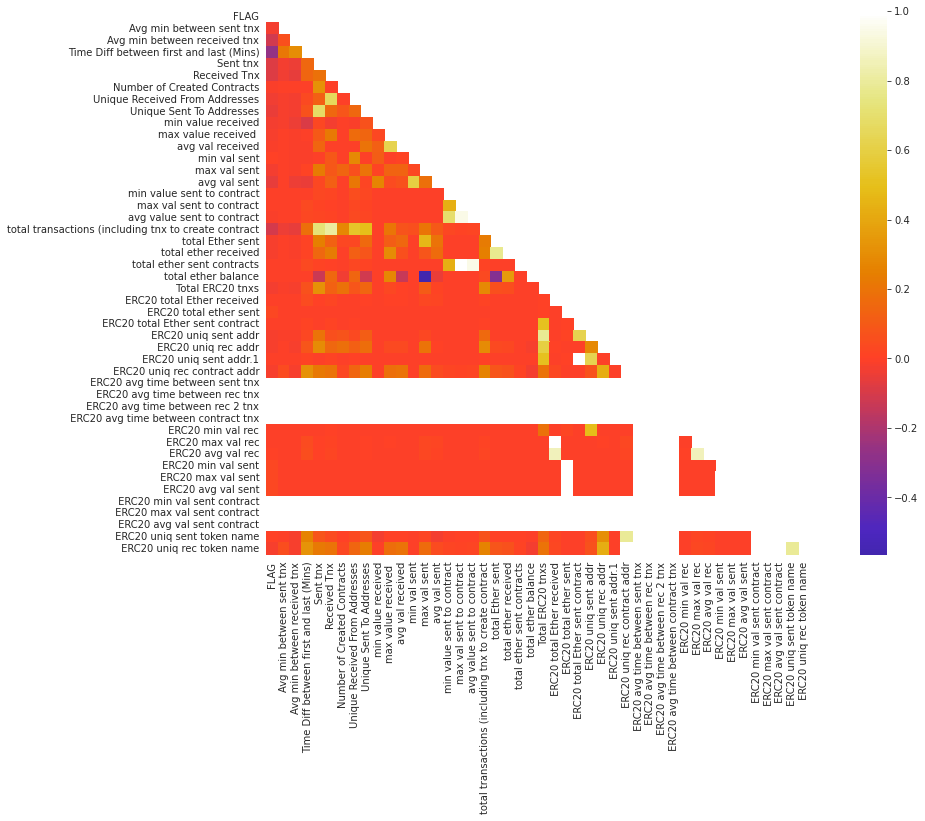

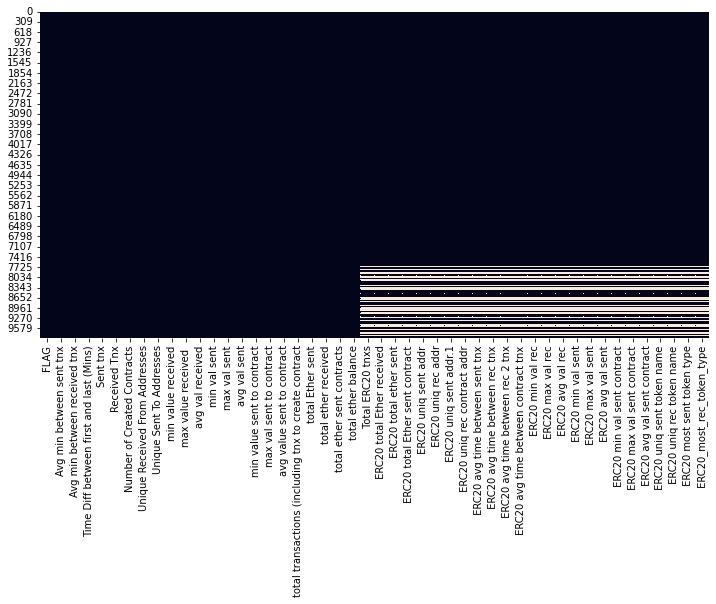

(9857, 46)


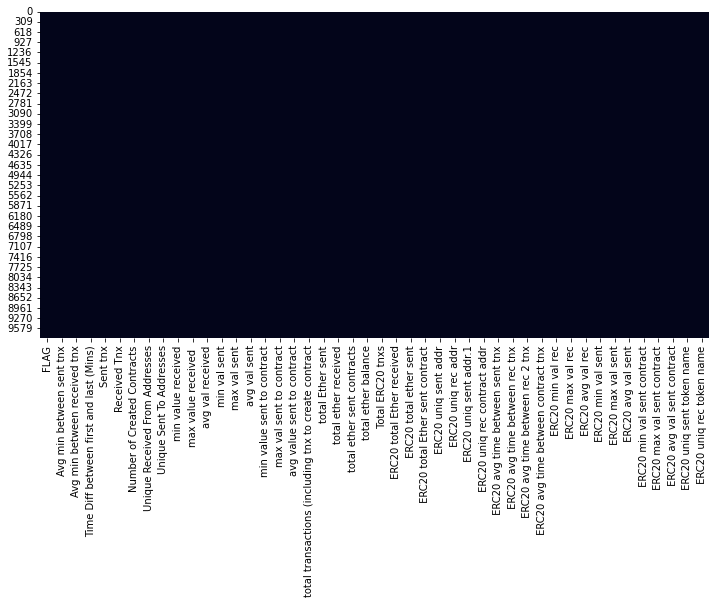

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.722106e-01
Avg min between sent tnx                                4.611421e+08
Avg min between received tnx                            5.733205e+08
Time Diff between first and last (Mins)                 1.056073e+11
Sent tnx                                                5.823974e+05
Received Tnx                                            9.330114e+05
Number of Created Contracts                             1.997440e+04
Unique Received From Addresses                          9.602837e+04
Unique Sent To Addresses                                7.202382e+04
min value received                                    

0it [00:00, ?it/s]

0    7678
1    2179
Name: FLAG, dtype: int64


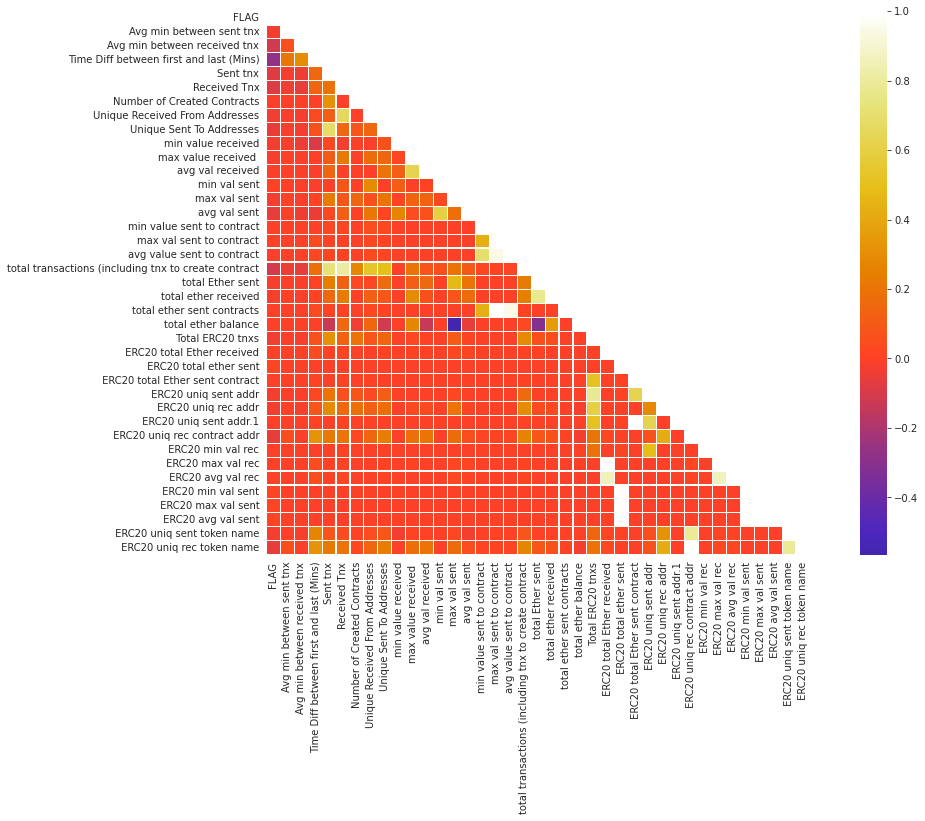

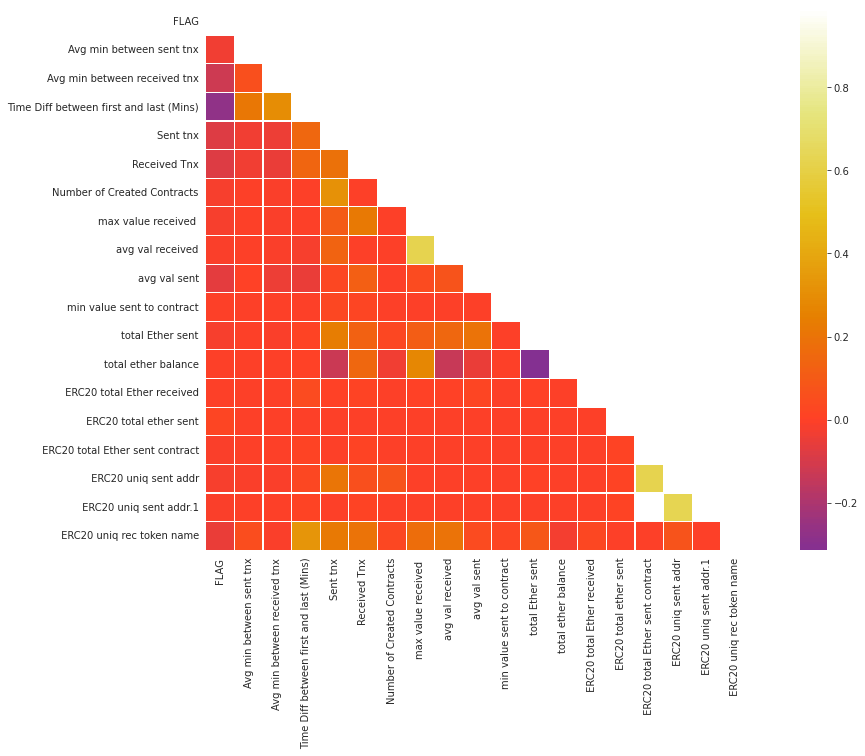

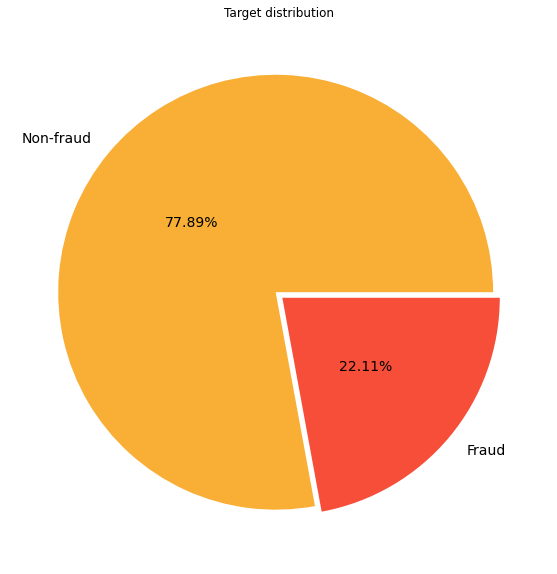

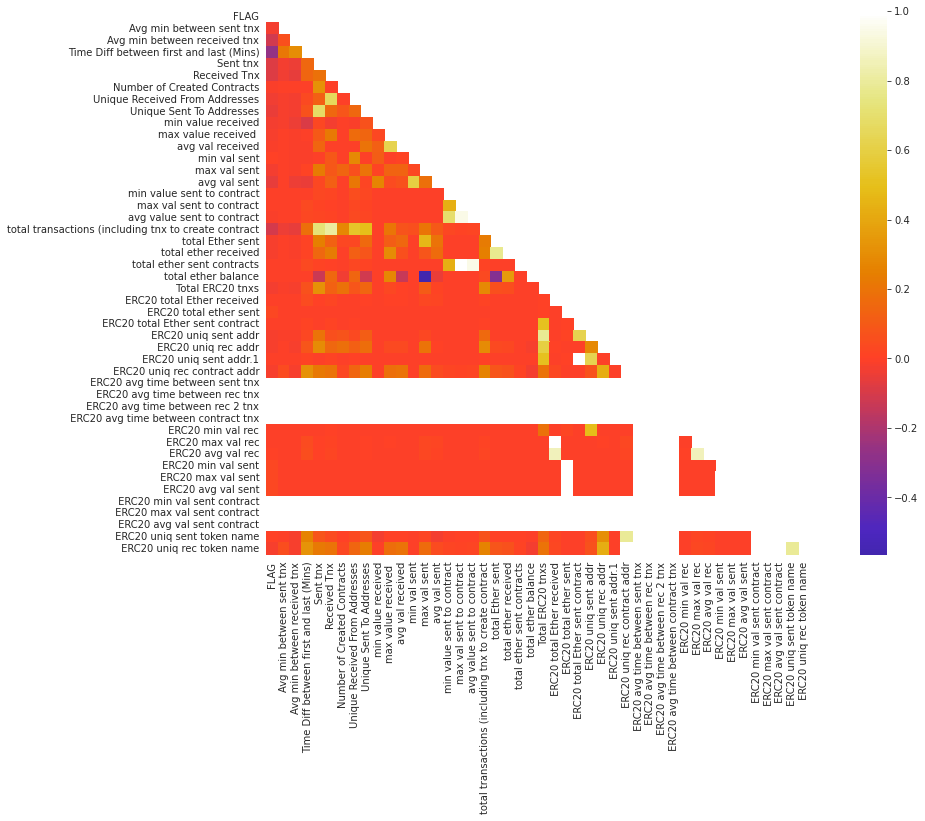

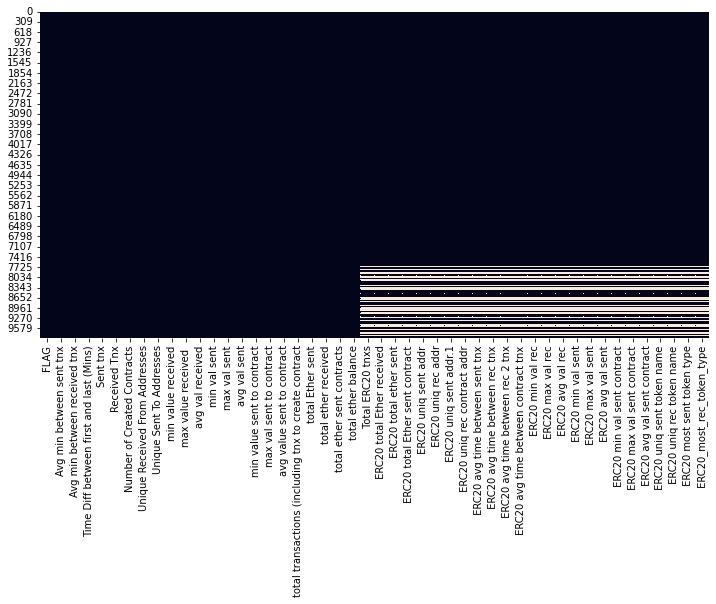

(9857, 46)


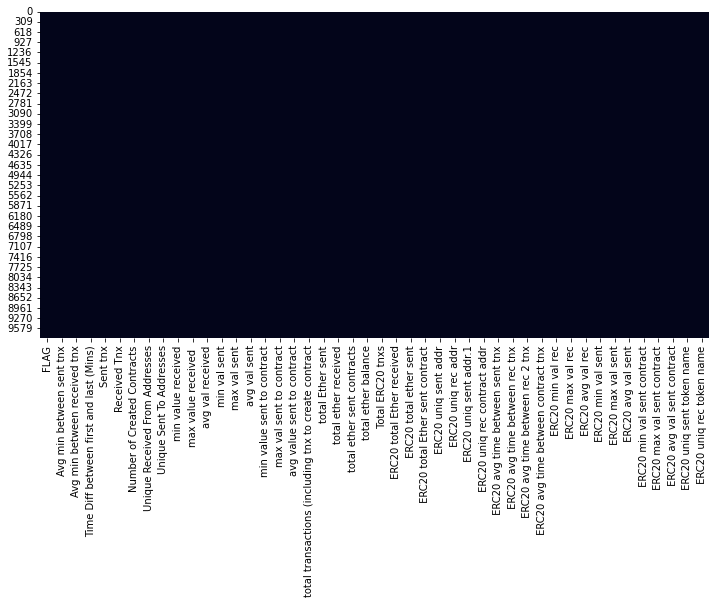

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.722106e-01
Avg min between sent tnx                                4.611421e+08
Avg min between received tnx                            5.733205e+08
Time Diff between first and last (Mins)                 1.056073e+11
Sent tnx                                                5.823974e+05
Received Tnx                                            9.330114e+05
Number of Created Contracts                             1.997440e+04
Unique Received From Addresses                          9.602837e+04
Unique Sent To Addresses                                7.202382e+04
min value received                                    

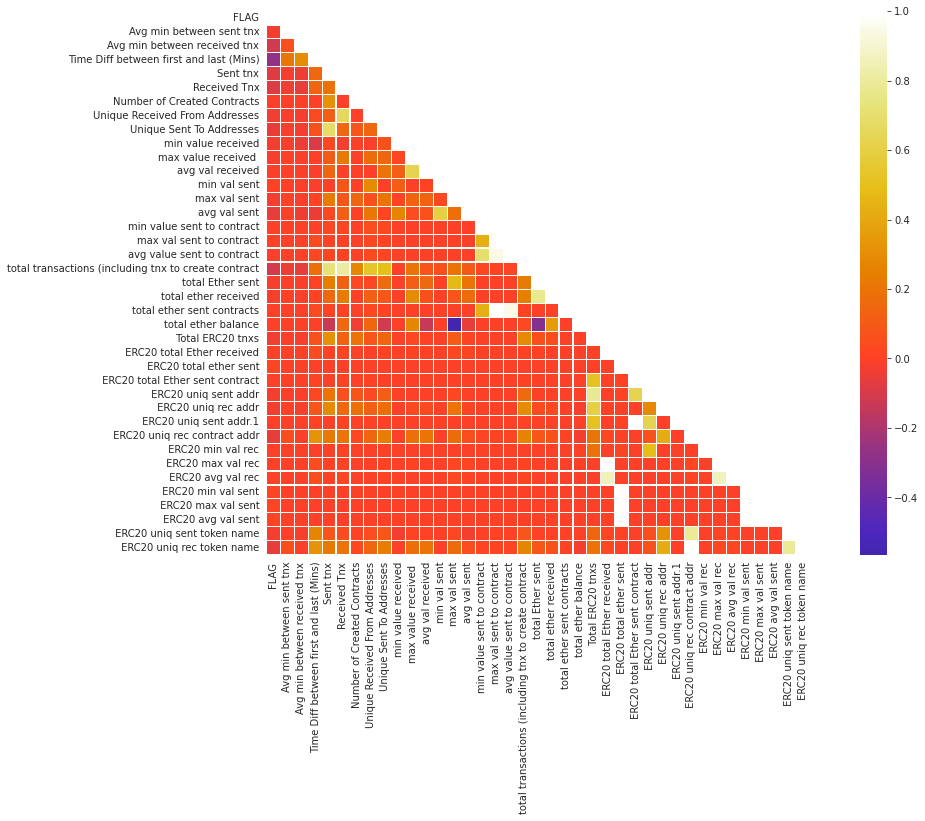

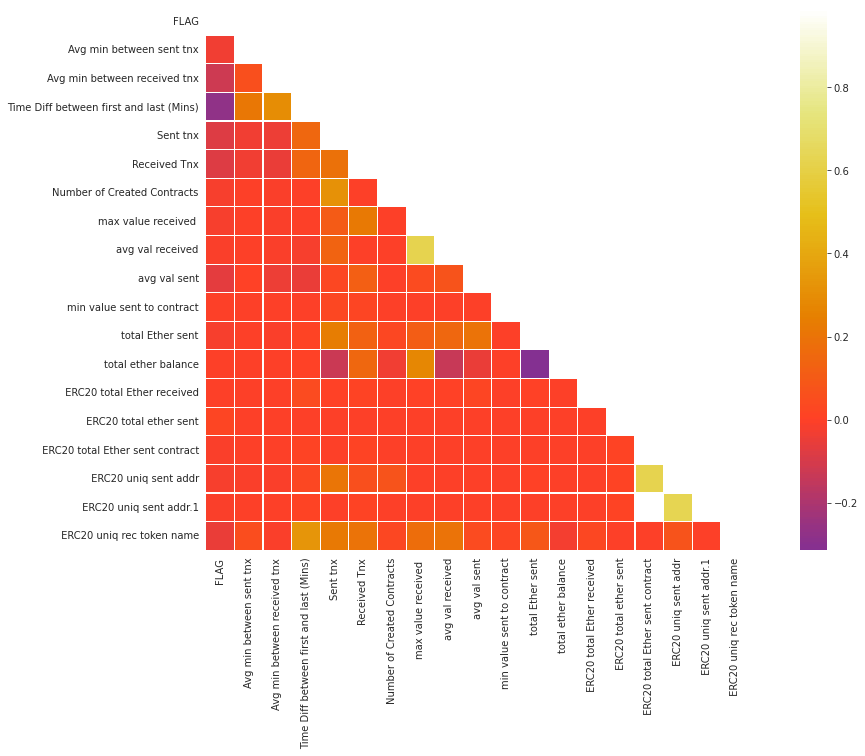

In [38]:
if __name__ == '__main__':
  i_w = '0x4886df279cc4946941e26de30b4011a2e92d2009'
  addresses = [i_w]
  new_addresses = []
  cdf = pd.read_csv('./transaction_dataset.csv', index_col=0)
  for ad in addresses:
    print(len(cdf))
    print(not any(ad.lower() == cdf['Address']))
    if not any(ad.lower() == cdf['Address']):
      new_addresses.append(ad)
  DTD = DataTool(direct=True)
  ndf = DTD.main(direct_addresses=new_addresses, idx=len(cdf))


  addresses1 = []
  new_addresses1 = []
  AC_Score = 0.0
  KYC_T = "None"
  AC_Balance = 0.0
  Past_Fraud = 0
  clean_addresses = True
  for address in addresses:
    if any(address.lower() == cdf['Address']):
      print(cdf[address.lower() == cdf['Address']]['FLAG'])
      Past_Fraud = (cdf[address.lower() == cdf['Address']]['FLAG']).item()
      print(Past_Fraud, "\n\n\n\n\n\n")
    if Past_Fraud == 1:
      clean_addresses = False
    data_list_NT, WoIT_NT, KYC_NT  = DTD.main_nw(direct_addresses=[address],clean_addresses=clean_addresses, idx=len(cdf),mode=0)
    data_list_TT, WoIT_TT, KYC_TT = DTD.main_nw(direct_addresses=[address],clean_addresses=clean_addresses, idx=len(cdf),mode=1)
    data_list_NFT, WoIT_NFT, KYC_NFT = DTD.main_nw(direct_addresses=[address],clean_addresses=clean_addresses, idx=len(cdf),mode=2)
    AC_Balance = DTD.account_balance(address)
    print("AB: ", AC_Balance)
    if KYC_T == "None":
      KYC_T = KYC_NT if KYC_NT != "None" else (KYC_TT if KYC_TT != "None" else KYC_NFT)
    WoIT_NT = list(WoIT_NT.items())
    WoIT_TT = list(WoIT_TT.items())
    WoIT_NFT = list(WoIT_NFT.items())
    for item in WoIT_NT:
      if (len(item[0].lower()) == 42 and item[0].lower() != '0x0000000000000000000000000000000000000000' and item[0].lower()[:2] == '0x'):
        addresses1.append(item[0].lower())
    for item in WoIT_TT:
      if (len(item[0].lower()) == 42 and item[0].lower() != '0x0000000000000000000000000000000000000000' and item[0].lower()[:2] == '0x'):
        addresses1.append(item[0].lower())
    for item in WoIT_NFT:
      if (len(item[0].lower()) == 42 and item[0].lower() != '0x0000000000000000000000000000000000000000' and item[0].lower()[:2] != '0x'):
        addresses1.append(item[0].lower())

    print(len(addresses1))
    addresses1 = list(set(addresses1))
    print(len(addresses1))
    print(addresses1)
    print(WoIT_NT)
    print(WoIT_TT)
    print(WoIT_NFT, "\n\n\n\n========================================KYC: ", KYC_T)
    print(ndf)
    MLC = ML_Core()
    print(address)
    preds, pred_prob = MLC.run_ML(address)
    if preds == -1:
      break
    print(preds, pred_prob)
    print(data_list_NT)
    if(Past_Fraud == 0):
      Past_Fraud = (1-preds)
    else:
      Past_Fraud = 1-Past_Fraud
    AC_Score += Past_Fraud*(300 + 300*pred_prob[0][0])
  for ad in addresses1:
    print(len(cdf))
    print(ad.lower() == cdf['Address'])
    if not any(ad.lower() == cdf['Address']) and ad.lower()[:2] != '0x':
      new_addresses1.append(ad)

  DTD = DataTool(direct=True)
  ndf = DTD.main(direct_addresses=new_addresses1, idx=len(cdf))

  values_list = []
  for address in addresses1:

    MLC = ML_Core()
    preds, pred_prob = MLC.run_ML(address)
    if preds == -1:
      break
    values_list.append([preds, pred_prob])
  
  print(values_list, "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", len(addresses1))

  sum_ch = 0.0
  for ad1 in range(len(values_list)):
    sum_ch += values_list[ad1][1][0][0]
  
  if (len(values_list) > 0):
    sum_ch /= len(values_list)
  AC_Score += Past_Fraud*(sum_ch*100 + (100 if KYC_T != "Null" else 0))
  gdf = pd.read_csv('./node_outlier_scores.csv', index_col=0)
  df_ig = gdf[gdf['address'] == i_w.lower()]
  df_ig = df_ig[['AdONE','ANOMALOUS','CoLA','CONAD','DOMINANT','DONE','GAAN','GCNAE','MLPAE','Radar','SCAN']]
  df_ig_v = 1-0.5
  print(df_ig_v)
  AC_Score += Past_Fraud*(50 * df_ig_v if any(gdf['address'] == i_w.lower()) else 50 * 0.5)
  print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", sum_ch, "\n", AC_Score, Past_Fraud)

In [42]:
from mmap import ACCESS_COPY
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.core.reshape.pivot import AggFuncType 
import seaborn as sns
import warnings

from traitlets.config.loader import KeyValueConfigLoader
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle
import streamlit as st
from datetime import date
from plotly import graph_objs as go
import graphviz


wallet = st.text_input("Wallet Address: ")

@st.cache
def load_data(wallet):
    data = pd.read_csv('./transaction_dataset.csv', index_col=0)
    return data



addresses = [wallet]
new_addresses = []
cdf = pd.read_csv('./transaction_dataset.csv', index_col=0)
for ad in addresses:
  print(len(cdf))
  print(not any(ad.lower() == cdf['Address']))
  if not any(ad.lower() == cdf['Address']):
    new_addresses.append(ad)
DTD = DataTool(direct=True)
ndf = DTD.main(direct_addresses=new_addresses, idx=len(cdf))


addresses1 = []
new_addresses1 = []
AC_Score = 0.0
KYC_T = "None"
AC_Balance = 0.0
Past_Fraud = 0
clean_addresses = True
Fraud_chance = [100.0, 0.0]
AC_Age = 0.0
for address in addresses:
  if any(address.lower() == cdf['Address']):
    print(cdf[address.lower() == cdf['Address']]['FLAG'])
    Past_Fraud = (cdf[address.lower() == cdf['Address']]['FLAG']).item()
    AC_Age = (cdf[address.lower() == cdf['Address']]['Time Diff between first and last (Mins)']).item()
    print(Past_Fraud, "\n\n\n\n\n\n")
  if Past_Fraud == 1:
    clean_addresses = False
  data_list_NT, WoIT_NT, KYC_NT  = DTD.main_nw(direct_addresses=[address],clean_addresses=clean_addresses, idx=len(cdf),mode=0)
  data_list_TT, WoIT_TT, KYC_TT = DTD.main_nw(direct_addresses=[address],clean_addresses=clean_addresses, idx=len(cdf),mode=1)
  data_list_NFT, WoIT_NFT, KYC_NFT = DTD.main_nw(direct_addresses=[address],clean_addresses=clean_addresses, idx=len(cdf),mode=2)
  AC_Balance = DTD.account_balance(address)
  print("AB: ", AC_Balance)
  if KYC_T == "None":
    KYC_T = KYC_NT if KYC_NT != "None" else (KYC_TT if KYC_TT != "None" else KYC_NFT)
  WoIT_NT = list(WoIT_NT.items())
  WoIT_TT = list(WoIT_TT.items())
  WoIT_NFT = list(WoIT_NFT.items())
  for item in WoIT_NT:
    if (len(item[0].lower()) == 42 and item[0].lower() != '0x0000000000000000000000000000000000000000' and item[0].lower()[:2] == '0x'):
      addresses1.append(item[0].lower())
  for item in WoIT_TT:
    if (len(item[0].lower()) == 42 and item[0].lower() != '0x0000000000000000000000000000000000000000' and item[0].lower()[:2] == '0x'):
      addresses1.append(item[0].lower())
  for item in WoIT_NFT:
    if (len(item[0].lower()) == 42 and item[0].lower() != '0x0000000000000000000000000000000000000000' and item[0].lower()[:2] != '0x'):
      addresses1.append(item[0].lower())

  print(len(addresses1))
  addresses1 = list(set(addresses1))
  print(len(addresses1))
  print(addresses1)
  print(WoIT_NT)
  print(WoIT_TT)
  print(WoIT_NFT, "\n\n\n\n========================================KYC: ", KYC_T)
  print(ndf)
  MLC = ML_Core()
  print(address)
  preds, pred_prob = MLC.run_ML(address)
  if preds == -1:
    break
  print(preds, pred_prob)
  print(data_list_NT)
  Fraud_chance = pred_prob[0]
  if(Past_Fraud == 0):
    Past_Fraud = (1-preds)
  else:
    Past_Fraud = 1-Past_Fraud
  AC_Score += Past_Fraud*(300 + 300*pred_prob[0][0])
for ad in addresses1:
  print(len(cdf))
  print(ad.lower() == cdf['Address'])
  if not any(ad.lower() == cdf['Address']) and ad.lower()[:2] != '0x':
    new_addresses1.append(ad)

DTD = DataTool(direct=True)
ndf = DTD.main(direct_addresses=new_addresses1, idx=len(cdf))

values_list = []
for address in addresses1:

  MLC = ML_Core()
  preds, pred_prob = MLC.run_ML(address)
  if preds == -1:
    break
  values_list.append([preds, pred_prob])

print(values_list, "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", len(addresses1))

sum_ch = 0.0
for ad1 in range(len(values_list)):
  sum_ch += values_list[ad1][1][0][0]

if (len(values_list) > 0):
  sum_ch /= len(values_list)
AC_Score += Past_Fraud*(sum_ch*100 + (100 if KYC_T != "Null" else 0))
gdf = pd.read_csv('./node_outlier_scores.csv', index_col=0)
df_ig = gdf[gdf['address'] == wallet.lower()]
df_ig = df_ig[['AdONE','ANOMALOUS','CoLA','CONAD','DOMINANT','DONE','GAAN','GCNAE','MLPAE','Radar','SCAN']]
df_ig_v = 1-0.5
print(df_ig_v)
AC_Score += Past_Fraud*(50 * df_ig_v if any(gdf['address'] == wallet.lower()) else 50 * 0.5)
print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", sum_ch, "\n", AC_Score, Past_Fraud)




data = load_data(wallet)
st.write('The current wallet is', wallet)
col1, col2, col3 = st.columns(3)
col1.metric("Accoutability Score", AC_Score, "0%")
col2.metric("Active Account Age(mins)", AC_Age, "")
col3.metric("KYC", KYC_T, "")
col1.metric("Balance", AC_Balance, "")
col2.metric("Past Fraud", 1-Past_Fraud, "")
col3.metric("Fraud Chance", 1-Fraud_chance[0], "")

st.write('How we generate the Accoutability Score:')
y = np.array([70, 15, 15])
mylabels = ["ML", "Graph_Scoring", "Analytical_Scoring"]
plt.pie(y, labels = mylabels, startangle = 90)
st.pyplot(plt)
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> ML
        ML -> Transaction_Metrics
        Transaction_Metrics -> Transaction_Time_Metrics
        Transaction_Metrics -> Transaction_Amount_Metrics
        Transaction_Metrics -> Transaction_Direction
        Transaction_Metrics -> Unique_Addresses
        ML -> Contracts_Created
        ML -> ERC20_Token_Types
    }
''')
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> Graph_Scoring
        Graph_Scoring -> Transaction_Analysis
        Graph_Scoring -> Anomely_Detection
    }
''')
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> Analytical_Scoring
        Analytical_Scoring -> Transaction_Analysis
        Analytical_Scoring -> Account_Analysis
        Account_Analysis -> KYC
        Account_Analysis -> Account_Metrics
        Transaction_Analysis -> NFT_Tracking
        Transaction_Analysis -> Web_of_Implied_Trust
        Analytical_Scoring -> User_Input
        Analytical_Scoring -> Other_Metrics

    }
''')


  command:

    streamlit run /usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2022-12-13 07:19:56.046 
  command:

    streamlit run /usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py [ARGUMENTS]


9857
True


  0%|          | 0/1 [00:01<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


ValueError: ignored

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle
import streamlit as st
from datetime import date
from plotly import graph_objs as go

launch code cell this should be added in launch.py file

In [ ]:
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle
import streamlit as st
from datetime import date
from plotly import graph_objs as go

wallet = st.text_input("Wallet Address: ")

df = pd.read_csv('./transaction_dataset.csv', index_col=0)

@st.cache
def load_data(wallet):
    data = pd.read_csv('./transaction_dataset.csv', index_col=0)
    return data

data_load_state = st.text('Loading data...')
data = load_data(wallet)
data_load_state.text('Loading data... done!')

st.subheader('Raw data')
st.write(data.head())
st.write(df.describe())
st.write(df.var())
# Ommit first two columns (Index, Adress)
df = df.iloc[:,2:]
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
st.write(df[categories])
# Inspect numericals
numericals = df.select_dtypes(include=['float','int']).columns
st.write(df[numericals].describe())
st.write(df[numericals].var())
#--
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
st.pyplot(plt)
#--
# Correlation matrix
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)
    st.pyplot(fig)
#---
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
st.pyplot(plt)
#-------
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
st.pyplot(plt)
#------
# Filtering the features with 0 variance
no_var = df.var() == 0
st.write(df.var()[no_var])


# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
st.write(df.var())
st.write(df.shape)
#------
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)
    st.pyplot(fig)
  
#------
#Drop one of those highly correlated features
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)
    st.pyplot(fig)
#------
columns = df.columns
# Investigate the distribution of our features using boxplots
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')
 
ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')
 
ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')
 
ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

st.pyplot(plt)

#----

# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
st.write(df.shape)
st.write(df.head())

#--------

df = df.sample(frac = 1.0)
y = df.iloc[:, 0].to_numpy()
X = df.iloc[:, 1:].to_numpy()
st.write(X.shape, y.shape)
st.write("Sum To Train")
st.write(sum(y))
#-----------
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
precisionList = []
print(kf)

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("sum of y_train")
    print(sum(y_train))
    
    # Normalize the training features
    norm = PowerTransformer()
    norm_train_f = norm.fit_transform(X_train)
    
    oversample = SMOTE()
    print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')
    x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
    print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')
    
    # Target distribution before SMOTE
    non_fraud = 0
    fraud = 0

    for i in y_train:
        if i == 0:
            non_fraud +=1
        else:
            fraud +=1

    # Target distribution after SMOTE
    no = 0
    yes = 1

    for j in y_tr_resample:
        if j == 0:
            no +=1
        else:
            yes +=1


    print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
    print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')
    
    LR = LogisticRegression(random_state=42)
    LR.fit(x_tr_resample, y_tr_resample)

    # Transform test features
    norm_test_f = norm.transform(X_test)

    preds = LR.predict(norm_test_f)
    # print(preds)
    #print(classification_report(y_test, preds))
    dict = classification_report(y_test, preds, output_dict=True)
    precisionList.append(dict['0']['precision'])
    
    print(confusion_matrix(y_test, preds))
    plot_confusion_matrix(LR, norm_test_f, y_test)
ave = sum(precisionList) / len(precisionList)
var = sum((i - ave) ** 2 for i in precisionList) / len(precisionList)
st.write("Precision Info: ")
st.write("Minimum Precision: " + str(min(precisionList)))
st.write("Maximum Precision: " + str(max(precisionList)))
st.write("Average Precision: " + str(ave))
st.write("Variance Precision: " + str(var))

"""

In [ ]:
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle
import streamlit as st
from datetime import date
from plotly import graph_objs as go
import graphviz


wallet = st.text_input("Wallet Address: ")

df = pd.read_csv('./transaction_dataset.csv', index_col=0)

@st.cache
def load_data(wallet):
    data = pd.read_csv('./transaction_dataset.csv', index_col=0)
    return data


data = load_data(wallet)
score = 725
score_pt = str(score)+"/850"
st.write('The current wallet is', wallet)
col1, col2, col3 = st.columns(3)
col1.metric("Accoutability Score", score_pt, "0%")
col2.metric("KYC", "Via(Coinbase)", "+")
col3.metric("Past Fraud", "None", "+")
col1.metric("Fraud Chance", "86% No Fraud", "+")
col2.metric("Balance", "246.6 Eth", "+")
col3.metric("Other Validation", "IPP", "+")
col1.metric("Reports", "None", "")

st.write('How we generate the Accoutability Score(ML+Graph_Scoring+Direct_Scoring):')
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> ML
        Accoutability_Score -> Graph_Scoring
        Accoutability_Score -> Direct_Scoring
    }
''')
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> ML
        ML -> Transaction_Metrics
        Transaction_Metrics -> Transaction_Time_Metrics
        Transaction_Metrics -> Transaction_Amount_Metrics
        Transaction_Metrics -> Transaction_Direction
        Transaction_Metrics -> Unique_Addresses
        ML -> Contracts_Created
        ML -> ERC20_Token_Types
    }
''')
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> Graph_Scoring
        Graph_Scoring -> Transaction_Analysis
        Graph_Scoring -> Anomely_Detection
    }
''')
st.graphviz_chart('''
    digraph {
        Accoutability_Score -> Direct_Scoring
        Direct_Scoring -> Transaction_Analysis
        Direct_Scoring -> Account_Analysis
        Account_Analysis -> KYC
        Account_Analysis -> Account_Age
        Transaction_Analysis -> NFT_Tracking
        Transaction_Analysis -> Web_of_Implied_Trust
        Direct_Scoring -> User_Input
        Direct_Scoring -> Other_Metrics

    }
''')

st.subheader('Raw data')
st.write(data.head())
st.write(df.describe())
st.write(df.var())
# Ommit first two columns (Index, Adress)
df = df.iloc[:,2:]
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
st.write(df[categories])
# Inspect numericals
numericals = df.select_dtypes(include=['float','int']).columns
st.write(df[numericals].describe())
st.write(df[numericals].var())
#--
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
st.pyplot(plt)
#--
# Correlation matrix
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)
    st.pyplot(fig)
#---
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
st.pyplot(plt)
#-------
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
st.pyplot(plt)
#------
# Filtering the features with 0 variance
no_var = df.var() == 0
st.write(df.var()[no_var])


# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
st.write(df.var())
st.write(df.shape)
#------
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)
    st.pyplot(fig)
  
#------
#Drop one of those highly correlated features
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)
    st.pyplot(fig)
#------
columns = df.columns
# Investigate the distribution of our features using boxplots
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')
 
ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')
 
ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')
 
ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

st.pyplot(plt)

#----

# Some features present a small distribution
#for i in df.columns[1:]:
#    if len(df[i].value_counts()) < 10:
#        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
#        print('======================================')

drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
st.write(df.shape)
st.write(df.head())

#--------

df = df.sample(frac = 1.0)
y = df.iloc[:, 0].to_numpy()
X = df.iloc[:, 1:].to_numpy()
st.write(X.shape, y.shape)
st.write("Sum To Train")
st.write(sum(y))
#-----------
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
precisionList = []
#print(kf)

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)
    #print("sum of y_train")
    #print(sum(y_train))
    
    # Normalize the training features
    norm = PowerTransformer()
    norm_train_f = norm.fit_transform(X_train)
    
    oversample = SMOTE()
    #print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')
    x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
    #print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')
    
    # Target distribution before SMOTE
    non_fraud = 0
    fraud = 0

    for i in y_train:
        if i == 0:
            non_fraud +=1
        else:
            fraud +=1

    # Target distribution after SMOTE
    no = 0
    yes = 1

    for j in y_tr_resample:
        if j == 0:
            no +=1
        else:
            yes +=1


    #print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
    #print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')
    
    LR = LogisticRegression(random_state=42)
    LR.fit(x_tr_resample, y_tr_resample)

    # Transform test features
    norm_test_f = norm.transform(X_test)

    preds = LR.predict(norm_test_f)
    # print(preds)
    #print(classification_report(y_test, preds))
    dict = classification_report(y_test, preds, output_dict=True)
    precisionList.append(dict['0']['precision'])
    
    #print(confusion_matrix(y_test, preds))
    plot_confusion_matrix(LR, norm_test_f, y_test)
ave = sum(precisionList) / len(precisionList)
var = sum((i - ave) ** 2 for i in precisionList) / len(precisionList)
st.write("Precision Info: ")
st.write("Minimum Precision: " + str(min(precisionList)))
st.write("Maximum Precision: " + str(max(precisionList)))
st.write("Average Precision: " + str(ave))
st.write("Variance Precision: " + str(var))
"""

In [ ]:
df = pd.read_csv('transaction_dataset.csv', index_col=0)
df.head()


In [44]:
!streamlit run ML.py & npx localtunnel --port 8501

npx: installed 22 in 1.849s
your url is: https://modern-seas-make-34-145-200-10.loca.lt



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.145.200.10:8501

9857
True
  0% 0/1 [00:00<?, ?it/s][0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  0% 0/1 [00:00<?, ?it/s]
2022-12-13 07:23:47.367 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 564, in _run_script
    exec(code, module.__dict__)
  File "/content/ML.py", line 615, in <module>
    AC_Balance = DTD.account_balance(address)
  File "/content/ML.py", line 533, in account_balance
    return int(data['result']) / 1000000000000000000 if data['status'] != 0 else 0
ValueError: invalid literal for int() with base 10: 'Max rate limit reached'
9857
False
0it [00:00, ?it/s]
1942    0
Name: FLAG, dtype: int64
0 






AB:  16.106656985